# 5. Calibration of double ended measurement with OLS

A double ended calibration is performed with Ordinary Least Squares. Over all timesteps simultaneous. $\gamma$ and $\alpha$ remain constant, while $C$ varies over time. The weights are considered equal here and no variance or confidence interval is calculated.

Note that the internal reference section can not be used since there is a connector between the internal and external fiber and therefore the integrated differential attenuation cannot be considered to be linear anymore.

In [8]:
import os

from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt

%matplotlib inline

In [12]:
filepath = os.path.join('..', '..', 'tests', 'data', 'single_ended')

ds = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    timezone_input_files='Europe/Amsterdam',
    file_ext='*.xml')

ds100 = ds.sel(x=slice(-30, 101))  # only calibrate parts of the fiber, in meters
sections = {
            'probe1Temperature':    [slice(20, 25.5)],  # warm bath
            'probe2Temperature':    [slice(5.5, 15.5)],  # cold bath
            }
ds100.sections = sections

3 files were found, each representing a single timestep
4 recorded vars were found: LAF, ST, AST, TMP
Recorded at 1461 points along the cable
The measurement is single ended


In [13]:
print(ds100.calibration_single_ended.__doc__)



        Parameters
        ----------
        store_p_cov : str
            Key to store the covariance matrix of the calibrated parameters
        store_p_val : str
            Key to store the values of the calibrated parameters
        nt : int, optional
            Number of timesteps. Should be defined if method=='external'
        z : array-like, optional
            Distances. Should be defined if method=='external'
        p_val
        p_var
        p_cov
        sections : dict, optional
        st_label : str
            Label of the forward stokes measurement
        ast_label : str
            Label of the anti-Stoke measurement
        st_var : float, optional
            The variance of the measurement noise of the Stokes signals in the forward
            direction Required if method is wls.
        ast_var : float, optional
            The variance of the measurement noise of the anti-Stokes signals in the forward
            direction. Required if method is wls.
   

In [14]:
ds100.calibration_single_ended(st_label='ST',
                               ast_label='AST',
                               method='ols')

Lets compare our calibrated values with the device calibration

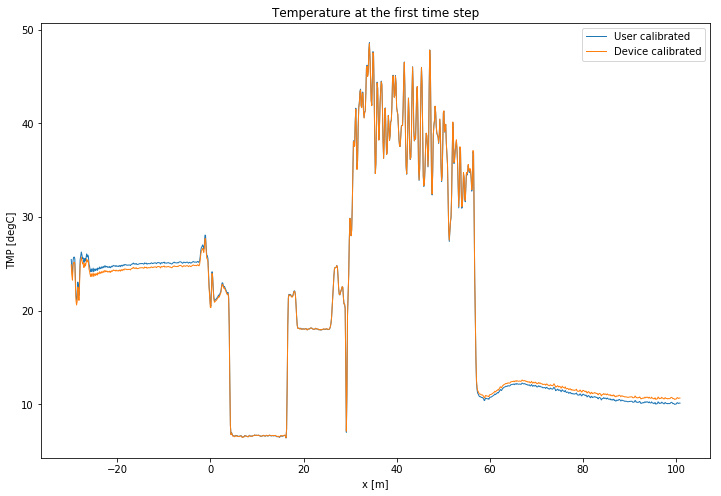

In [17]:
ds1 = ds100.isel(time=0)  # take only the first timestep

ds1.TMPF.plot(linewidth=1, figsize=(12, 8), label='User calibrated')  # plot the temperature calibrated by us
ds1.TMP.plot(linewidth=1, label='Device calibrated')  # plot the temperature calibrated by the device
plt.title('Temperature at the first time step')
plt.legend();